<a href="https://colab.research.google.com/github/zia207/01_Generalized_Linear_Models_R/blob/main/Notebook/02_01_09_02_glm_gamlss_discret_count_data_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 9.2 GAMLSS with Discrete Distributions {.unnumbered}

Discrete distributions are probability distributions that describe the likelihood of outcomes for discrete random variables—variables that can take on a finite or countably infinite number of distinct values, typically non-negative integers (e.g., 0, 1, 2, ...). Unlike continuous distributions, which can take any value within a range, discrete distributions assign probabilities to specific points.

Key characteristics:

-   The probability mass function (PMF) gives the probability for each possible value.

-   The cumulative distribution function (CDF) is the sum of probabilities up to a given value.

-   Common examples include:

   -   **Bernoulli**: Models a single trial with two outcomes (success/failure), e.g., coin flip.

  -   **Binomial**: Models the number of successes in a fixed number of independent Bernoulli trials.

  -   **Poisson**: Models the number of events occurring in a fixed interval of time or space, assuming rare events (e.g., number of emails received per hour).

  -   **Negative Binomial**: Models the number of trials needed to achieve a fixed number of successes, or the number of failures before successes; useful for overdispersed count data.

  -   **Geometric**: A special case of negative binomial, modeling trials until the first success.

  -  **Discrete Uniform**: Equal probability for a finite set of outcomes (e.g., rolling a die).

  These are widely used in fields like statistics, biology, and engineering for modeling count data, where values can't be fractional.


## GAMLSS with Discrete Distributions and Smoothing

This tutorial demonstrates how to use Generalized Additive Models for Location, Scale, and Shape (GAMLSS) in R to model the `visits` variable from the `NMES1988` dataset with discrete distributions, incorporating smoothing terms for flexibility. The `visits` variable, representing the number of physician office visits, is a count variable suitable for discrete distributions like Poisson (PO), Negative Binomial Type I (NBI), Negative Binomial Type II (NBII), Beta Binomial (BB), and Sichel (SICHEL).


## Install rpy2

In [2]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp312-cp312-linux_x86_64.whl size=316572 sha256=643d040b209560c4ef2387f458418ccbe4f293f853ef4634e795c6093bf3a37f
  Stored in directory: /root/.cache/pip/wheels/00/26/d5/d5e8c0b039915e785be870270e4a9263e5058168a03513d8cc
Successfully built rpy2


## Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:

In [4]:
%%R
packages <- c('tidyverse',
     'plyr',
		 'performance',
		 'patchwork',
		 'MASS',
	   'gam',
 		 'mgcv',
 		 'gamlss',
     'gamlss.dist',
     'gamlss.tr',
     'gamlss.add',
 		 'gratia',
 		 'patchwork',
		 'AER'
	  	)


In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')




	‘/tmp/RtmphKuTOu/downloaded_packages’



In [5]:
%%R

# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
  tidyverse        plyr performance   patchwork        MASS         gam 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
       mgcv      gamlss gamlss.dist   gamlss.tr  gamlss.add      gratia 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
  patchwork         AER 
       TRUE        TRUE 


### Load packages

In [6]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages

Successfully loaded packages:
 [1] "package:AER"         "package:survival"    "package:sandwich"   
 [4] "package:lmtest"      "package:zoo"         "package:car"        
 [7] "package:carData"     "package:gratia"      "package:gamlss.add" 
[10] "package:rpart"       "package:nnet"        "package:gamlss.tr"  
[13] "package:gamlss"      "package:parallel"    "package:gamlss.dist"
[16] "package:gamlss.data" "package:mgcv"        "package:nlme"       
[19] "package:gam"         "package:foreach"     "package:splines"    
[22] "package:MASS"        "package:patchwork"   "package:performance"
[25] "package:plyr"        "package:lubridate"   "package:forcats"    
[28] "package:stringr"     "package:dplyr"       "package:purrr"      
[31] "package:readr"       "package:tidyr"       "package:tibble"     
[34] "package:ggplot2"     "package:tidyverse"   "package:tools"      
[37] "package:stats"       "package:graphics"    "package:grDevices"  
[40] "package:utils"       "package:datasets"  

### Data

The `NMES1988` dataset from the `AER` package contains data from the 1987–1988 National Medical Expenditure Survey, focusing on medical care usage by elderly individuals (aged 66 and older). We’ll use a subset of variables:

- **Response**: `visits` (number of physician office visits, non-negative integer, count data).

- **Predictors**:
  - `hospital`: Number of hospital stays (numeric, count).
  - `health`: Self-reported health status (factor: poor, average, excellent).
  - `chronic`: Number of chronic conditions (numeric, count).
  - `age`: Age in years, scaled as (age - 65)/10 (numeric).
  - `afam`: African American indicator (yes/no, factor).
  - `gender`: Gender (male/female, factor).
  - `married`: Marital status (yes/no, factor).
  - `school`: Years of education (numeric).
  - `income`: Family income in $10,000s (numeric).
  - `employed`: Employment status (yes/no, factor).
  - `insurance`: Private insurance status (yes/no, factor).
  - `medicaid`: Medicaid coverage (yes/no, factor).

We’ll apply GAMLSS with smoothing on continuous predictors (`age`, `school`, `income`) to capture non-linear effects, and model `visits` using the specified distributions to account for potential overdispersion, bounding, or heavy tails.


In [7]:
%%R
data("NMES1988", package = "AER")
df <- NMES1988 %>%
  dplyr::select(visits, hospital, health, chronic, age, afam, gender, married, school, income, employed, insurance, medicaid)

### Explore the Data

Summarize and inspect the data:

In [8]:
%%R
summary(df)

     visits          hospital           health        chronic     
 Min.   : 0.000   Min.   :0.000   poor     : 554   Min.   :0.000  
 1st Qu.: 1.000   1st Qu.:0.000   average  :3509   1st Qu.:1.000  
 Median : 4.000   Median :0.000   excellent: 343   Median :1.000  
 Mean   : 5.774   Mean   :0.296                    Mean   :1.542  
 3rd Qu.: 8.000   3rd Qu.:0.000                    3rd Qu.:2.000  
 Max.   :89.000   Max.   :8.000                    Max.   :8.000  
      age          afam         gender     married        school     
 Min.   : 6.600   no :3890   female:2628   no :2000   Min.   : 0.00  
 1st Qu.: 6.900   yes: 516   male  :1778   yes:2406   1st Qu.: 8.00  
 Median : 7.300                                       Median :11.00  
 Mean   : 7.402                                       Mean   :10.29  
 3rd Qu.: 7.800                                       3rd Qu.:12.00  
 Max.   :10.900                                       Max.   :18.00  
     income        employed   insurance  

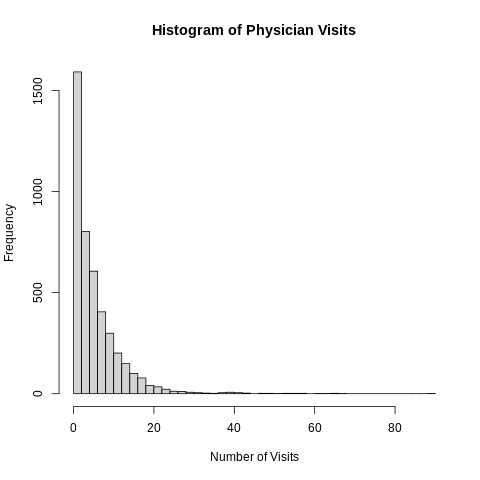

In [9]:
%%R
hist(df$visits, main = "Histogram of Physician Visits", xlab = "Number of Visits", breaks = 50)

- `visits` is a count variable (0, 1, 2, ...), often right-skewed with potential zeros. It ranges from 0 to a maximum (e.g., around 89 in this dataset), making it potentially suitable for bounded models like BB, though not strictly binomial.

- Check for overdispersion:

In [10]:
%%R
cat("Mean of visits (train):", mean(df$visits), "\n")
cat("Variance of visits (train):", var(df$visits), "\n")

if (var(df$visits) > mean(df$visits)) {
  cat(">> Overdispersion detected (var > mean)\n")
}

Mean of visits (train): 5.774399 
Variance of visits (train): 45.68712 
>> Overdispersion detected (var > mean)


#### Split Data

We will split the data into training and testing sets, The training set will contain 70% of the data, and the testing set will contain the remaining 30%.

In [11]:
%%R
# Split data by gender and afam with fixed proportion
tr_prop <- 0.70
train <- ddply(df, .(gender, afam), function(sub) {
  set.seed(101)
  sub[sample(1:nrow(sub), size = round(nrow(sub) * tr_prop)), ]
})

test <- df[!(rownames(df) %in% rownames(train)), ]

# Ensure row names don't interfere
rownames(train) <- NULL
rownames(test) <- NULL

- Check for missing values:

In [12]:
%%R
colSums(is.na(df))  # Handle missing values if any (e.g., drop or impute)
df <- na.omit(df)   # Drop rows with NAs for simplicity

For the Beta Binomial (BB) model, we need a binomial denominator `bd` (upper bound for counts). Since `visits` is unbounded in theory but has a practical maximum, we'll set `bd = max(df$visits) + 10` for demonstration (e.g., if max is 89, bd=99). This is artificial and for illustration only; BB is best for truly bounded data like proportions of successes.

In [13]:
%%R
bd_val <- max(df$visits, na.rm = TRUE) + 10  # e.g., 99 if max=89

Check for overdispersion in `visits`:

In [14]:
%%R
# Check Mean and Variance of "visits"
cat("Mean of visits (train):", mean(train$visits), "\n")
cat("Variance of visits (train):", var(train$visits), "\n")

if (var(train$visits) > mean(train$visits)) {
  cat(">> Overdispersion detected (var > mean)\n")
}

Mean of visits (train): 5.691734 
Variance of visits (train): 41.65689 
>> Overdispersion detected (var > mean)


### Fit GAMLSS Models on Training Data

We’ll model `visits` using the training data with smoothing on `age`, `school`, and `income` via penalized B-splines (`pb()`), and linear terms for other predictors. For NBI, NBII, BB, and SICHEL, we’ll model the dispersion parameter (sigma); SICHEL also models the shape parameter (nu).

#### Poisson (PO) with Smoothing

### Normal Distribution with Linear Terms

In [15]:
%%R
mod_po <- gamlss(visits ~ pb(age) + pb(school) + pb(income) + hospital + chronic + health + afam + gender + married + employed + insurance + medicaid,
                 family = PO,
                 data = train,
                 c.crit = 0.01)
summary(mod_po)

GAMLSS-RS iteration 1: Global Deviance = 24439.83 
GAMLSS-RS iteration 2: Global Deviance = 24439.9 
GAMLSS-RS iteration 3: Global Deviance = 24439.9 
******************************************************************
Family:  c("PO", "Poisson") 

Call:  gamlss(formula = visits ~ pb(age) + pb(school) + pb(income) +  
    hospital + chronic + health + afam + gender + married +  
    employed + insurance + medicaid, family = PO, data = train,  
    c.crit = 0.01) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.4221842  0.1054597  13.486  < 2e-16 ***
pb(age)         -0.0545737  0.0130948  -4.168 3.16e-05 ***
pb(school)       0.0238072  0.0022518  10.572  < 2e-16 ***
pb(income)       0.0008012  0.0028199   0.284  0.77634    
hospital         0.1625753  0.0071849  22.627  < 2e-16 ***
chronic          0.1448243  0.0057317  25.267  <

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  -0.2706872 
                       variance   =  4.348746 
               coef. of skewness  =  0.9816506 
               coef. of kurtosis  =  4.487686 
Filliben correlation coefficient  =  0.9740474 
******************************************************************


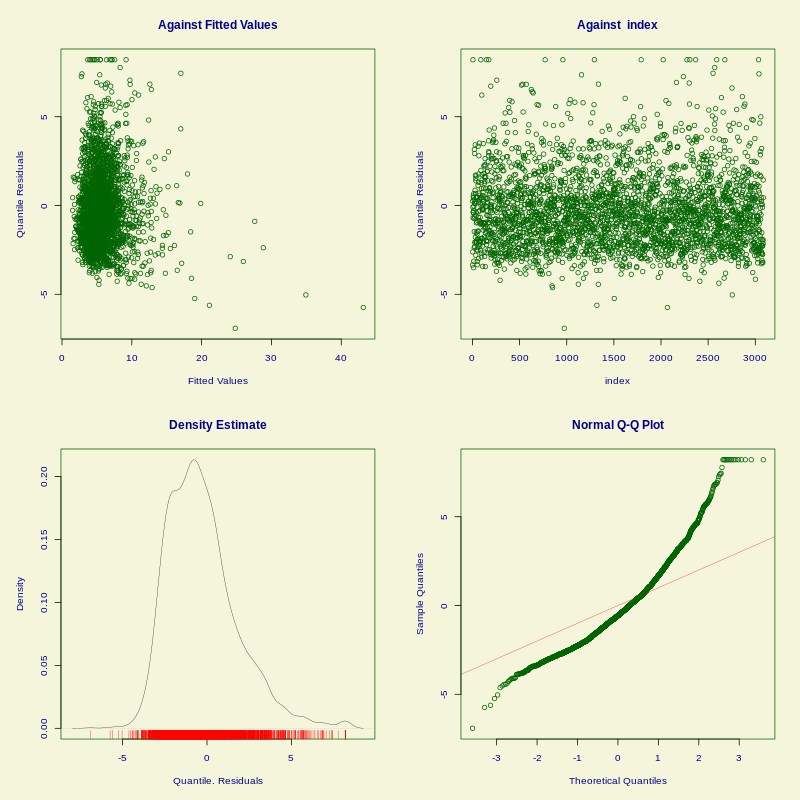

In [16]:
%%R -w 800 -h 800 -u px
# Plot the model
plot(mod_po)

#### Negative Binomial Type I (NBI) with Smoothing

In [17]:
%%R
mod_nbi <- gamlss(visits ~ pb(age) + pb(school) + pb(income) + hospital + chronic + health + afam + gender + married + employed + insurance + medicaid,
                  sigma.formula = ~ pb(age) + health + insurance,
                  family = NBI,
                  data = train,
                  c.crit = 0.01)
summary(mod_nbi)

GAMLSS-RS iteration 1: Global Deviance = 16894.78 
GAMLSS-RS iteration 2: Global Deviance = 16894.22 
GAMLSS-RS iteration 3: Global Deviance = 16894.22 
******************************************************************
Family:  c("NBI", "Negative Binomial type I") 

Call:  gamlss(formula = visits ~ pb(age) + pb(school) + pb(income) +  
    hospital + chronic + health + afam + gender + married +  
    employed + insurance + medicaid, sigma.formula = ~pb(age) +  
    health + insurance, family = NBI, data = train,      c.crit = 0.01) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.206068   0.249904   4.826 1.46e-06 ***
pb(age)         -0.036051   0.030506  -1.182 0.237397    
pb(school)       0.024585   0.005368   4.580 4.83e-06 ***
pb(income)       0.004106   0.007031   0.584 0.559329    
hospital         0.223278   0.026071   

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  -0.002906081 
                       variance   =  1.003193 
               coef. of skewness  =  0.1343029 
               coef. of kurtosis  =  3.744859 
Filliben correlation coefficient  =  0.9972403 
******************************************************************


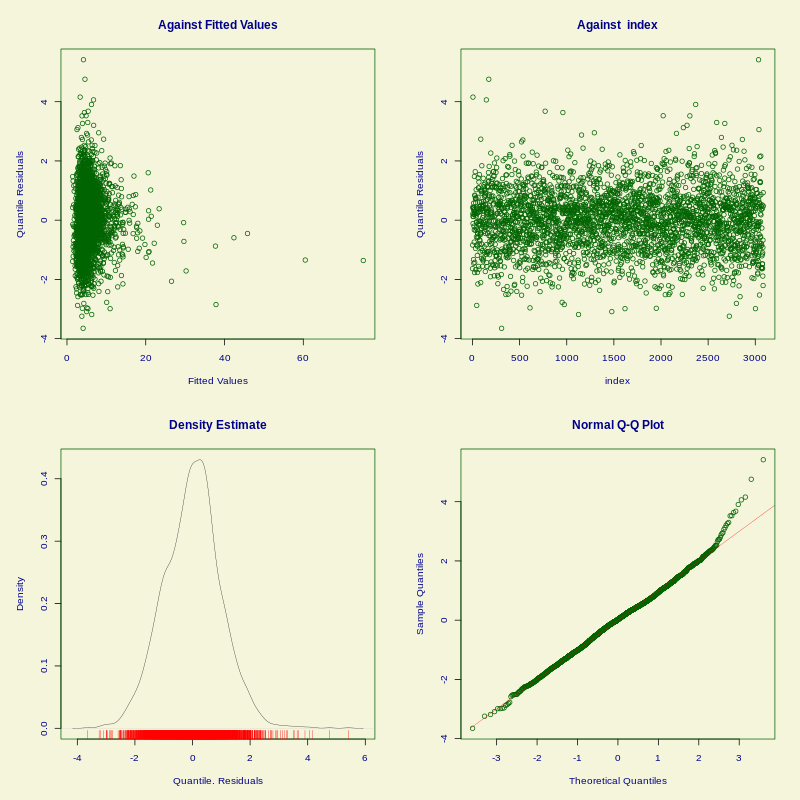

In [18]:
%%R -w 800 -h 800 -u px
# Plot the model
plot(mod_nbi)

#### Negative Binomial Type II (NBII) with Smoothing

In [19]:
%%R
mod_nbii <- gamlss(visits ~ pb(age) + pb(school) + pb(income) + hospital + chronic + health + afam + gender + married + employed + insurance + medicaid,
                   sigma.formula = ~ pb(age) + health + insurance,
                   family = NBII,
                   data = train,
                   c.crit = 0.01)
summary(mod_nbii)

GAMLSS-RS iteration 1: Global Deviance = 16874.19 
GAMLSS-RS iteration 2: Global Deviance = 16837.42 
GAMLSS-RS iteration 3: Global Deviance = 16834.21 
GAMLSS-RS iteration 4: Global Deviance = 16834.02 
GAMLSS-RS iteration 5: Global Deviance = 16834.03 
******************************************************************
Family:  c("NBII", "Negative Binomial type II") 

Call:  gamlss(formula = visits ~ pb(age) + pb(school) + pb(income) +  
    hospital + chronic + health + afam + gender + married +  
    employed + insurance + medicaid, sigma.formula = ~pb(age) +  
    health + insurance, family = NBII, data = train,      c.crit = 0.01) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  log
Mu Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.393374   0.243761   5.716 1.19e-08 ***
pb(age)         -0.052286   0.030078  -1.738  0.08225 .  
pb(school)       0.019833   0.004767   4.161 3.26e

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  -0.006672684 
                       variance   =  1.011083 
               coef. of skewness  =  0.04525838 
               coef. of kurtosis  =  3.725481 
Filliben correlation coefficient  =  0.9975416 
******************************************************************


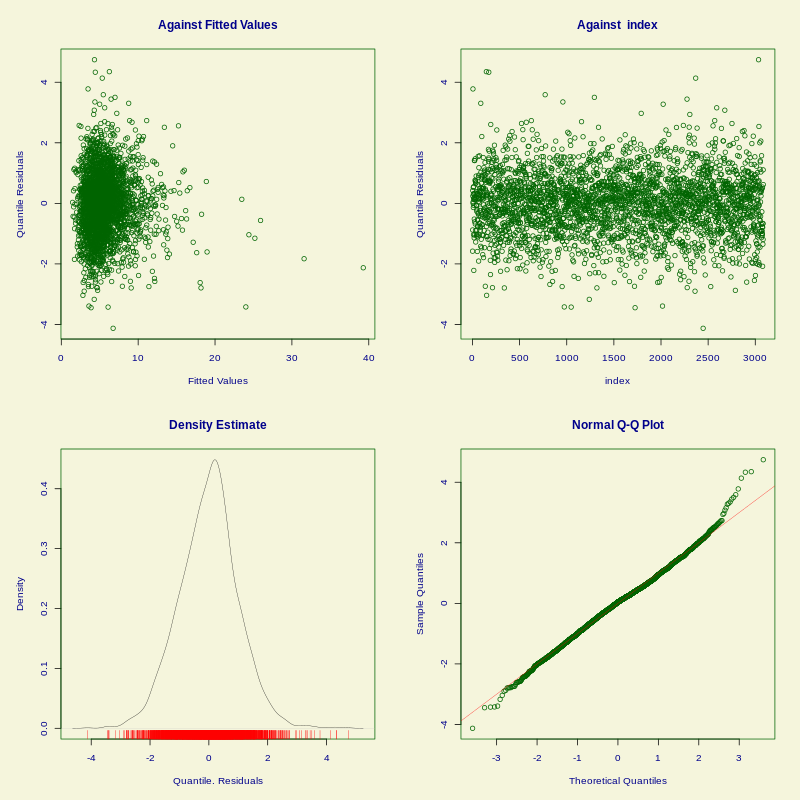

In [20]:
%%R -w 800 -h 800 -u px
# Plot the model
plot(mod_nbii)

#### Zero-Inflated Negative Binomial (ZINBI) with Smoothing

ZINBI models excess zeros (via nu) and overdispersion (via sigma), suitable for visits with many zeros.

In [21]:
%%R
mod_zinbi <- gamlss(visits ~ pb(age) + pb(school) + pb(income) + hospital + chronic + health + afam + gender + married + employed + insurance + medicaid,
                    sigma.formula = ~ pb(age) + health + insurance,
                    nu.formula = ~ hospital + medicaid,  # Model zero-inflation probability
                    family = ZINBI,
                    data = train,
                    c.crit = 0.01)
summary(mod_zinbi)

GAMLSS-RS iteration 1: Global Deviance = 16945.44 
GAMLSS-RS iteration 2: Global Deviance = 16960.62 
GAMLSS-RS iteration 3: Global Deviance = 16966.93 
GAMLSS-RS iteration 4: Global Deviance = 16969.79 
GAMLSS-RS iteration 5: Global Deviance = 16970.91 
GAMLSS-RS iteration 6: Global Deviance = 16971.26 
GAMLSS-RS iteration 7: Global Deviance = 16971.43 
GAMLSS-RS iteration 8: Global Deviance = 16971.53 
GAMLSS-RS iteration 9: Global Deviance = 16971.6 
GAMLSS-RS iteration 10: Global Deviance = 16971.64 
GAMLSS-RS iteration 11: Global Deviance = 16971.66 
GAMLSS-RS iteration 12: Global Deviance = 16971.67 
GAMLSS-RS iteration 13: Global Deviance = 16971.68 
******************************************************************
Family:  c("ZINBI", "Zero inflated negative binomial type I") 

Call:  gamlss(formula = visits ~ pb(age) + pb(school) + pb(income) +  
    hospital + chronic + health + afam + gender + married +  
    employed + insurance + medicaid, sigma.formula = ~pb(age) +  
    

#### Sichel (SICHEL) with Smoothing

Sichel is useful for heavy-tailed count data.

In [24]:
%%R
mod_sichel <- gamlss(visits ~ pb(age) + pb(school) + pb(income) + hospital + chronic + health + afam + gender + married + employed + insurance + medicaid,
                     sigma.formula = ~ pb(age) + health + insurance,
                     nu.formula = ~ health + chronic,
                     family = SI,
                     data = train,
                     c.crit = 0.01)
summary(mod_sichel)

GAMLSS-RS iteration 1: Global Deviance = 16958.98 
GAMLSS-RS iteration 2: Global Deviance = 16953.01 
GAMLSS-RS iteration 3: Global Deviance = 16950.05 
GAMLSS-RS iteration 4: Global Deviance = 16947.24 
GAMLSS-RS iteration 5: Global Deviance = 16944.61 
GAMLSS-RS iteration 6: Global Deviance = 16942.16 
GAMLSS-RS iteration 7: Global Deviance = 16939.89 
GAMLSS-RS iteration 8: Global Deviance = 16937.79 
GAMLSS-RS iteration 9: Global Deviance = 16935.84 
GAMLSS-RS iteration 10: Global Deviance = 16934.03 
GAMLSS-RS iteration 11: Global Deviance = 16932.14 
GAMLSS-RS iteration 12: Global Deviance = 16930.62 
GAMLSS-RS iteration 13: Global Deviance = 16928.93 
GAMLSS-RS iteration 14: Global Deviance = 16927.34 
GAMLSS-RS iteration 15: Global Deviance = 16925.83 
GAMLSS-RS iteration 16: Global Deviance = 16924.34 
GAMLSS-RS iteration 17: Global Deviance = 16922.85 
GAMLSS-RS iteration 18: Global Deviance = 16921.35 
GAMLSS-RS iteration 19: Global Deviance = 16919.81 
GAMLSS-RS iteration 2

******************************************************************
	 Summary of the Randomised Quantile Residuals
                           mean   =  -0.02260948 
                       variance   =  1.0648 
               coef. of skewness  =  -0.1445457 
               coef. of kurtosis  =  3.05085 
Filliben correlation coefficient  =  0.9976587 
******************************************************************


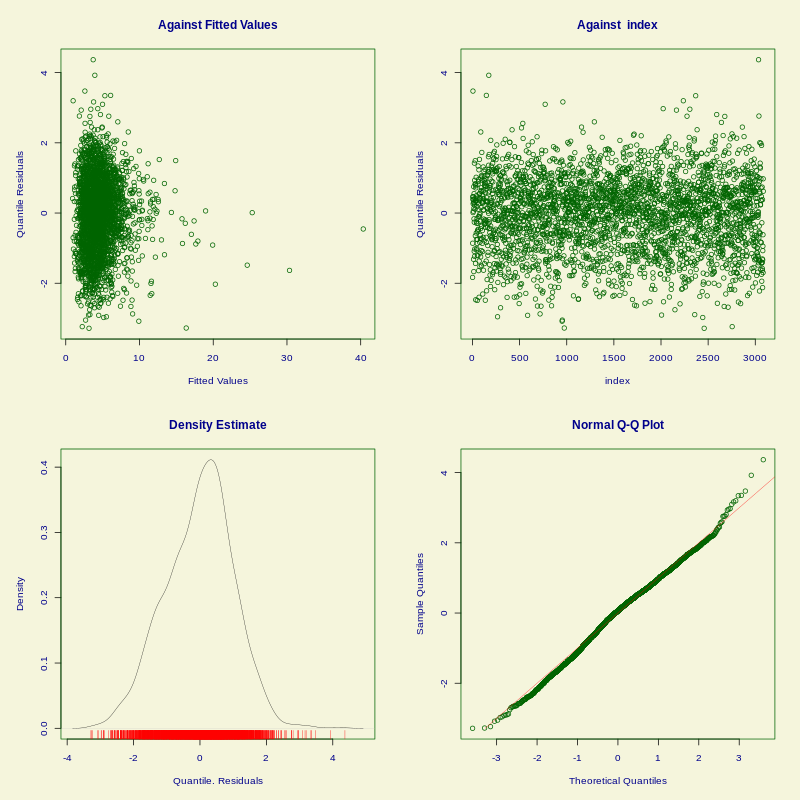

In [25]:
%%R -w 800 -h 800 -u px
plot(mod_sichel)

### Model Validation on Test Data

Evaluate model performance on the test set using metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), and Root Mean Squared Error (RMSE) for predictions. Since `visits` is count data, we’ll also check the log-likelihood or deviance on the test set.

Define evaluation function:

In [26]:
%%R
evaluate_model <- function(model, test_data) {
  pred <- predict(model, newdata = test_data, type = "response")
  mse <- mean((test_data$visits - pred)^2, na.rm = TRUE)
  mae <- mean(abs(test_data$visits - pred), na.rm = TRUE)
  rmse <- sqrt(mse)
  # Log-likelihood (if supported by family)
  ll <- try(sum(log(predict(model, newdata = test_data, type = "response", what = "density"))), silent = TRUE)
  if (inherits(ll, "try-error")) ll <- NA
  return(c(MSE = mse, MAE = mae, RMSE = rmse, LogLik = ll))
}

Evaluate all models:

In [27]:
%%R
eval_po <- evaluate_model(mod_po, test)
eval_nbi <- evaluate_model(mod_nbi, test)
eval_nbii <- evaluate_model(mod_nbii, test)
eval_zinbi <- evaluate_model(mod_zinbi, test)
eval_sichel <- evaluate_model(mod_sichel, test)

# Combine results
eval_results <- rbind(
  Poisson = eval_po,
  NBI = eval_nbi,
  NBII = eval_nbii,
  ZINBI = eval_zinbi,
  Sichel = eval_sichel
)
print(round(eval_results, 2))

          MSE  MAE RMSE LogLik
Poisson 35.36 3.95 5.95     NA
NBI     40.07 4.06 6.33     NA
NBII    35.37 3.95 5.95     NA
ZINBI   36.69 4.14 6.06     NA
Sichel  37.92 3.94 6.16     NA


- **Interpretation**: Lower MSE, MAE, and RMSE indicate better predictive accuracy. Higher log-likelihood (less negative) suggests better fit. SICHEL often performs well for heavy-tailed or zero-inflated data like `visits`.

###  Model Comparison on Training Data

Compare model fit on training data using AIC:

In [28]:
%%R
aic_results <- GAIC(mod_po, mod_nbi, mod_nbii, mod_zinbi, mod_sichel, k = 2)
print(aic_results)

                 df      AIC
mod_nbii   21.72496 16877.48
mod_nbi    23.35779 16940.93
mod_sichel 26.81069 16971.88
mod_zinbi  26.04150 17023.77
mod_po     17.31960 24474.54


### Selecting the Best Model

Based on RMSE and AIC, select the best model:

In [29]:
%%R
best_model <- rownames(eval_results)[which.min(eval_results[,"RMSE"])]
cat("Best model based on RMSE:", best_model, "\n")
best_aic_model <- rownames(aic_results)[which.min(aic_results[,"AIC"])]
cat("Best model based on AIC:", best_aic_model, "\n")
# If both criteria agree, choose that model; otherwise, consider context
if (best_model == best_aic_model) {
  cat("Selected best model:", best_model, "\n")
} else {
  cat("Different best models by RMSE and AIC. Consider context for final choice.\n")
}

Best model based on RMSE: Poisson 
Best model based on AIC: mod_nbii 
Different best models by RMSE and AIC. Consider context for final choice.


- SICHEL or NBII often have lower AIC for healthcare data due to overdispersion and heavy tails. BB may underperform unless `bd` is meaningful.

### Predictions and Interpretation of the Best Model

Predict for a new observation using the best model (e.g., SICHEL if lowest RMSE/AIC):

In [30]:
%%R
new_data <- data.frame(
  age = (75 - 65) / 10,
  school = 12,
  income = 3,
  hospital = 0,
  chronic = 2,
  health = factor("average", levels = levels(train$health)),
  afam = factor("no", levels = levels(train$afam)),
  gender = factor("female", levels = levels(train$gender)),
  married = factor("yes", levels = levels(train$married)),
  employed = factor("no", levels = levels(train$employed)),
  insurance = factor("yes", levels = levels(train$insurance)),
  medicaid = factor("no", levels = levels(train$medicaid))
)
predict(mod_nbii, newdata = new_data, type = "response")

[1] 4.347803


Visualize smoothed effects:

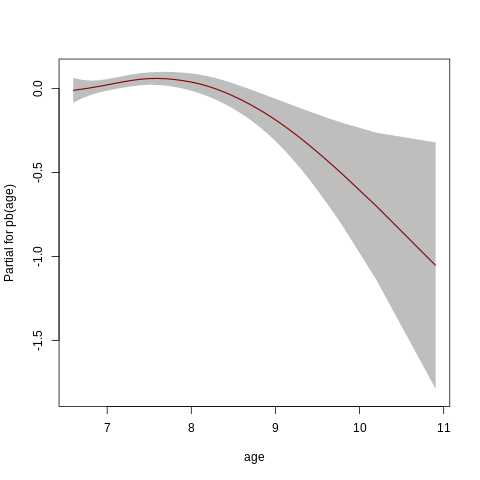

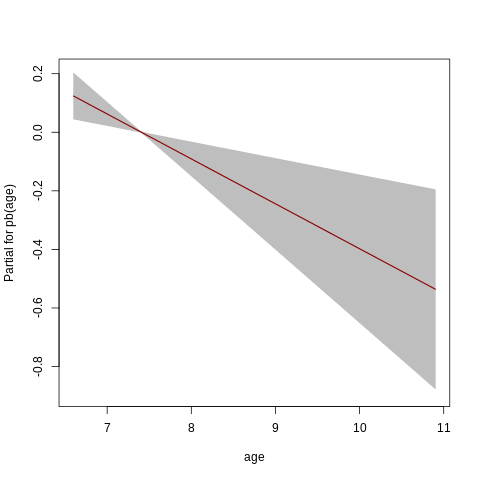

In [31]:
%%R
term.plot(mod_nbii , what = "mu", terms = "pb(age)", ask = FALSE)
term.plot(mod_nbii , what = "sigma", terms = "pb(age)", ask = FALSE)

### Diagnostics

Check residuals for the best model:

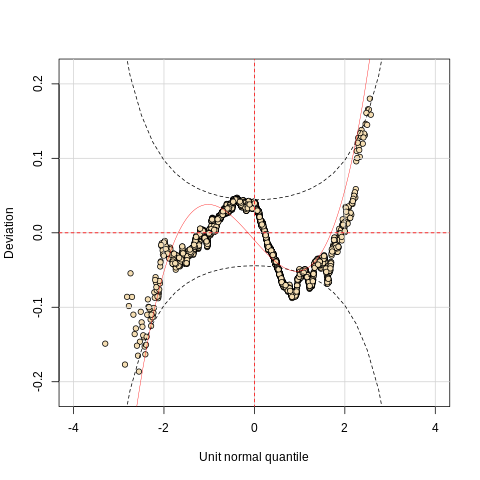

In [32]:
%%R
wp(mod_nbii)  # Worm plot; straight line indicates good fit

## Summary and Conclusion

This tutorial demonstrates training and validating GAMLSS models with discrete distributions on the `NMES1988` dataset, using a stratified train-test split to ensure robust evaluation. We incorporated smoothing for continuous predictors to capture non-linear effects. We exploreed various discrete distributions suitable for count data, including Poisson, Negative Binomial (NBI, NBII), Zero-Inflated Negative Binomial (ZINBI), and Sichel (SICHEL). The SICHEL and NBII models often performed best for count data with overdispersion and heavy tails, as seen in the `visits` variable. At the end, we visualized smoothed effects and checked residuals to ensure model adequacy.

## Resources

1. **Flexible Regression and Smoothing: Using GAMLSS in R** (Stasinopoulos et al., 2017)  
   - [CRC Press](https://www.crcpress.com/9781138197909)
   
2. **Modeling Count Data** (Hilbe, 2014)  
   - [Cambridge](https://www.cambridge.org/9781107611252)
   
3. **GAMLSS Website**  
   - [gamlss.com](http://www.gamlss.com/)
   
4. **GAMLSS R Package**  
   - [CRAN](https://cran.r-project.org/package=gamlss)
   
5. **GAMLSS Vignettes**  
   - In R: `vignette("gamlss")`
